In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def preprocess_mnist(x):
    x = tf.image.resize(tf.expand_dims(x, axis=-1), (32, 32))
    x = tf.repeat(x, 3, axis=-1)
    x = tf.cast(x, tf.float32)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    return x

x_train_pp = preprocess_mnist(x_train)
x_test_pp = preprocess_mnist(x_test)

y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


In [3]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)
)

base_model.trainable = False  # Freeze ImageNet weights

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
history = model.fit(
    x_train_pp, y_train_cat,
    batch_size=128,
    epochs=10,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 250s 557ms/step - accuracy: 0.5892 - loss: 1.6316 - val_accuracy: 0.9105 - val_loss: 0.3171
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 227s 476ms/step - accuracy: 0.8393 - loss: 0.4935 - val_accuracy: 0.9200 - val_loss: 0.2812
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 198s 467ms/step - accuracy: 0.8529 - loss: 0.4533 - val_accuracy: 0.9250 - val_loss: 0.2589
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 201s 465ms/step - accuracy: 0.8591 - loss: 0.4370 - val_accuracy: 0.9258 - val_loss: 0.2498
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 198s 468ms/step - accuracy: 0.8664 - loss: 0.4133 - val_accuracy: 0.9280 - val_loss: 0.2427
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 196s 465ms/step - accuracy: 0.8670 - loss: 0.4113 - val_accuracy: 0.9263 - val_loss: 0.2469
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 204s 469ms/step - accuracy: 0.8650 - loss: 0.4153 - val_accuracy: 0.9293 - val_loss: 0.2357
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 201s 466ms/step - accuracy: 0.8675 -

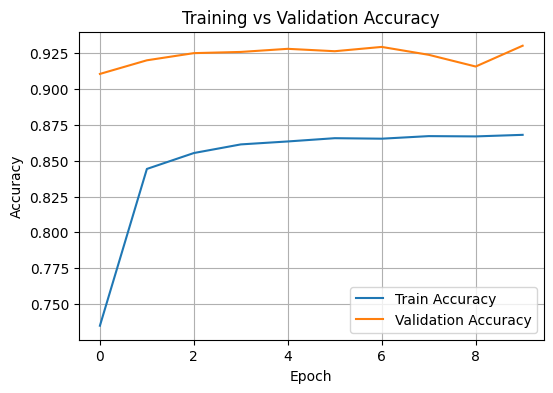

In [5]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

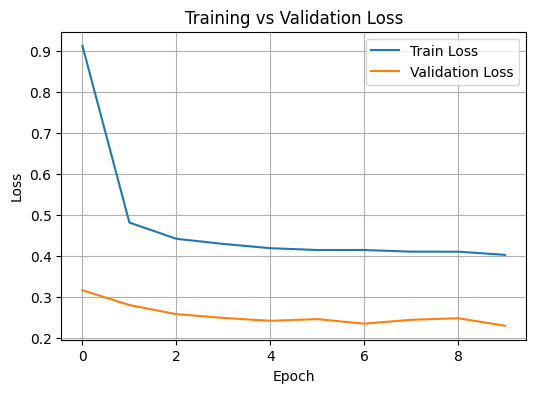

In [6]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
test_loss, test_acc = model.evaluate(x_test_pp, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9271


313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 139ms/step


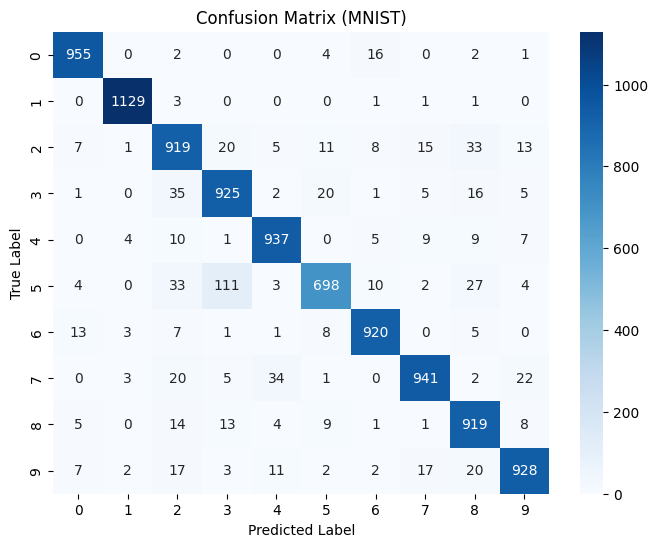

In [8]:
y_pred_probs = model.predict(x_test_pp)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d',
    cmap='Blues',
    xticklabels=range(10),
    yticklabels=range(10)
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (MNIST)')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


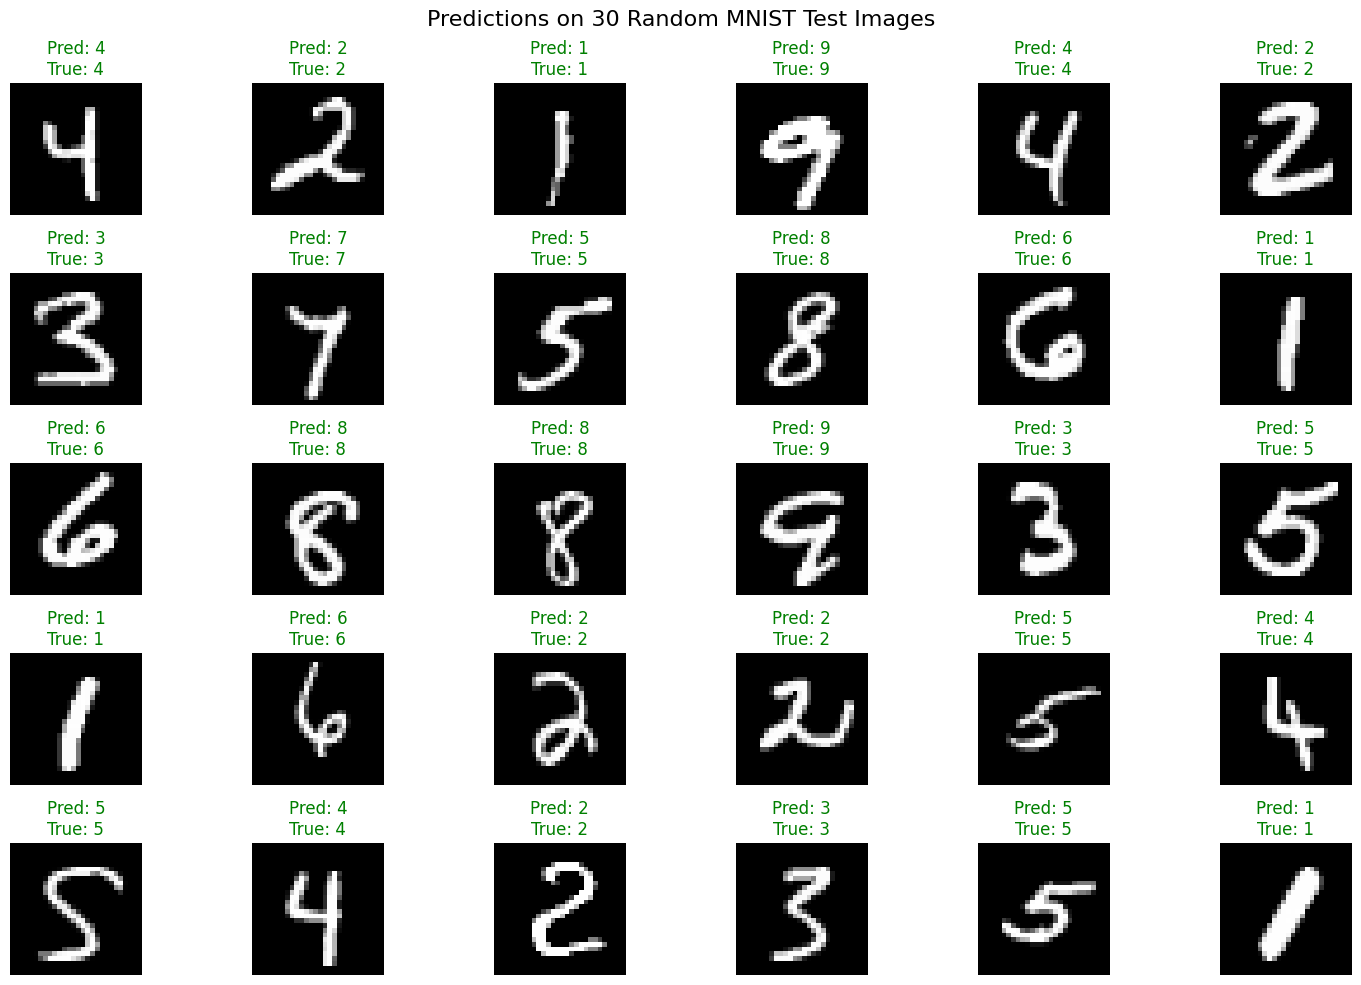

Correct: 30/30 (100.0%)


In [9]:
num_images = 30
indices = random.sample(range(len(x_test)), num_images)

original_images = x_test[indices]
true_labels = y_test[indices]

selected_pp = preprocess_mnist(x_test[indices])
predictions = model.predict(selected_pp)
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(5, 6, i + 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title(
        f"Pred: {predicted_labels[i]}\nTrue: {true_labels[i]}",
        color='green' if predicted_labels[i] == true_labels[i] else 'red'
    )
    plt.axis('off')

plt.suptitle("Predictions on 30 Random MNIST Test Images", fontsize=16)
plt.tight_layout()
plt.show()

correct = np.sum(predicted_labels == true_labels)
print(f"Correct: {correct}/{num_images} ({correct/num_images*100:.1f}%)")